# Regulome Explorer Notebook 

This notebook computes significant association scores between pairwise data types available in the PanCancer Atlas dataset of ISB-CGC. The specific statistical tests implmeneted are described ['here'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/RegulomeExplorerNotebooks.html#standard-pairwise-statistics),  and a description of the original Regulomen Explorer is avaiable ['here'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/RegulomeExplorerNotebooks.html#id5).

The output of the notebook is a table of significacnt associations specified by correltions and p-values. This notebook also performs a more detailed analysis from a user specified pair of features names generating figures and additional statistics.

### Authentication
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.github.io/google-cloud-python/latest/core/auth.html).

### Import Python libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from google.cloud import bigquery
import pandas as pd
import re_module.bq_functions as regulome

### Specify Parameters
The parameters for this experiment are the cancer type (study), a list of genes, a couple of molecular features (), the significance level, and the minimum number of samples required for the statistical analysis. 

In [2]:
[study, feature1, feature2, gene_names, size, cohortlist, significance] = regulome.makeWidgets()

### Build the query
The Bigquery query to compute associations between feature 1 and 2 are created using functions in the 'regulome' module. Please refer to our github repository to access the notebooks with description of the methods used for each possible combination of features available in TCGA: https://github.com/isb-cgc/Community-Notebooks/tree/master/RegulomeExplorer.

In [16]:
SampleList, PatientList  = regulome.readcohort( cohortlist )
LabelList = [ x.strip() for x in gene_names.value.split(',') ]

funct1 = regulome.approx_significant_level( )
table1, table2 = regulome.get_feature_tables(study.value,feature1.value,feature2.value,SampleList,PatientList,LabelList)
str_summarized = regulome.get_summarized_pancanatlas( feature1.value, feature2.value )
str_stats = regulome.get_stat_pancanatlas(feature1.value, feature2.value, size.value, significance.value  )

sql = (funct1 +  'WITH' + table1 + ',' + table2 + ',' + str_summarized + str_stats)
print(sql)

CREATE TEMP FUNCTION erfcc(x  FLOAT64)
RETURNS FLOAT64
LANGUAGE js AS """
  
  var t; 
  var z; 
  var ans;
  z = Math.abs(x) ;
  t = 1.0 / (1.0 + 0.5*z ) ;
  
  ans= t * Math.exp(-z*z-1.26551223+t*(1.00002368+t*(0.37409196+t*(0.09678418+
t*(-0.18628806+t*(0.27886807+t*(-1.13520398+t*(1.48851587+
t*(-0.82215223+t*0.17087277)))))))));
  
  if ( x >= 0 ) {
    return ans ;
  } else {
    return 2.0 - ans;
  }
""";

WITH
table1 AS (
SELECT
   symbol,
   (RANK() OVER (PARTITION BY symbol ORDER BY data ASC)) + (COUNT(*) OVER ( PARTITION BY symbol, CAST(data as STRING)) - 1)/2.0 AS rnkdata,
   ParticipantBarcode
FROM (
   SELECT
      Symbol AS symbol, 
      AVG( LOG10( normalized_count + 1 ) )  AS data,
      ParticipantBarcode AS ParticipantBarcode
   FROM `pancancer-atlas.Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered`
   WHERE Study = 'PAAD'    # cohort 
         AND Symbol IN UNNEST(@GENELIST)  # labels 
         AND normalized_count IS NOT NULL  
   GROUP BY
      P

### Run the Bigquery

In [17]:
bqclient = bigquery.Client()
df_results = regulome.runQuery ( bqclient, sql, LabelList, SampleList, PatientList, dryRun=False )
regulome.pvalues_dataframe( df_results )
df_results


 in runQuery ... 
    this query processed 7757877633 bytes 
    Approx. elpased time : 5605 miliseconds 


,symbol1,symbol2,n,correlation,p-value
0,SMAD4,WDR7,151,0.738707,0.000000
1,SMAD4,ZNF24,151,0.732436,0.000000
2,SMAD4,TSHZ1,151,0.727285,0.000000
3,SMAD4,DTNA,151,0.723987,0.000000
4,SMAD4,ELAC1,151,0.714381,0.000000
...,...,...,...,...,...
11757,SMAD4,FAM111A,151,-0.159906,0.049848
11758,SMAD4,ACER3,151,0.159878,0.049888
11759,SMAD4,LBR,151,0.159840,0.049944
11760,SMAD4,TIMD4,151,0.159830,0.049957


## Analyze a pair of labels
From the table above please select a pair of features names to perform a statistical analysis and display the data. You can print the variable 'pair_query' to obtain the query used to retrieve the data. 
**pair_query** is the query used to retreive the necessary data for the statistical test. 

In [7]:
[name1 , name2 ] = regulome.makeWidgetsPair()


 in runQuery ... 
    this query processed 7757877633 bytes 
    Approx. elpased time : 1264 miliseconds 
SpearmanrResult(correlation=0.7387068665040083, pvalue=2.6102587012639067e-27)


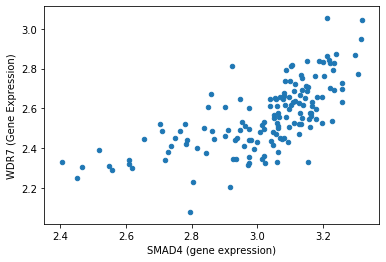

In [18]:
pair_query = regulome.get_query_pair(name1.value,name2.value,study.value,SampleList,feature1.value,feature2.value)
#print(pair_query)
df_pair = regulome.runQuery( bqclient, pair_query, LabelList, SampleList, PatientList, dryRun=False )
regulome.plot_statistics_pair ( df_pair, feature2.value, name1.value, name2.value, size.value )
